In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
from tqdm.auto import tqdm
import imageio
import einops
import torch
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST
device = torch.device("cuda:0")

In [2]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

In [3]:
# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
batch_size = 64

dataset = FashionMNIST("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

In [4]:
def show_forward(ddpm, loader, device):
    # Showing the forward process
    for batch in loader:
        imgs = batch[0]

        show_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]:
            show_images(
                ddpm(imgs.to(device),
                     [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]),
                f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

In [5]:
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100, gif_name="sampling.gif", c=1, h=28, w=28):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            writer.append_data(frame)
            if idx == len(frames) - 1:
                for _ in range(frames_per_gif // 3):
                    writer.append_data(frames[-1])
    return x

In [6]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 28, 28)):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

In [7]:
def training_loop(ddpm, loader, n_epochs, optim, device, scheduler=None,
                  display=False, store_path="ddpm_model_FMNIST.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        print(f'Epoch {epoch+1}/{n_epochs}')
        
        epoch_loss = 0.0
           
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # Loading data
            x0 = batch[0].to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)
        
        if scheduler is not None:
            scheduler.step()
        
        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Average loss: {epoch_loss:.3f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)
        print('-' * 75)

In [8]:
from UNetSmall import *
from CustomizableCosineDecayScheduler import CosineDecayWithWarmUpScheduler as CD_scheduler

In [9]:
try:
    del ddpm
except: pass

n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
ddpm = MyDDPM(UNetSmall(n_steps), n_steps=n_steps, 
              min_beta=min_beta, max_beta=max_beta, device=device)

optimizer = optim.Adam(ddpm.parameters(), betas=(0.7, 0.95),
                       lr=3e-4)

scheduler = CD_scheduler(optimizer, 
                    max_lr=3e-4, min_lr=1e-6, num_step_down=20, 
                    num_step_up=0, gamma=0.5, alpha=0.3)
ddpm.train()
training_loop(ddpm, loader, n_epochs=20, optim=optimizer, device=device,
             scheduler=scheduler)

Training progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20


Epoch 1/20:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.151 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 2/20


Epoch 2/20:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.070 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 3/20


Epoch 3/20:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.062 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 4/20


Epoch 4/20:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.058 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 5/20


Epoch 5/20:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.056 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 6/20


Epoch 6/20:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.053 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 7/20


Epoch 7/20:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.052 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 8/20


Epoch 8/20:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.051 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 9/20


Epoch 9/20:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.050 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 10/20


Epoch 10/20:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.049 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 11/20


Epoch 11/20:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.048 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 12/20


Epoch 12/20:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.047 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 13/20


Epoch 13/20:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.047 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 14/20


Epoch 14/20:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.046 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 15/20


Epoch 15/20:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.046
---------------------------------------------------------------------------
Epoch 16/20


Epoch 16/20:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.046 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 17/20


Epoch 17/20:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.045 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 18/20


Epoch 18/20:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.045
---------------------------------------------------------------------------
Epoch 19/20


Epoch 19/20:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.045 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 20/20


Epoch 20/20:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.044 --> Best model ever (stored)
---------------------------------------------------------------------------


In [11]:
store_path="ddpm_model_FMNIST.pt"
best_model = MyDDPM(UNetSmall(), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

Model loaded


Generating new images


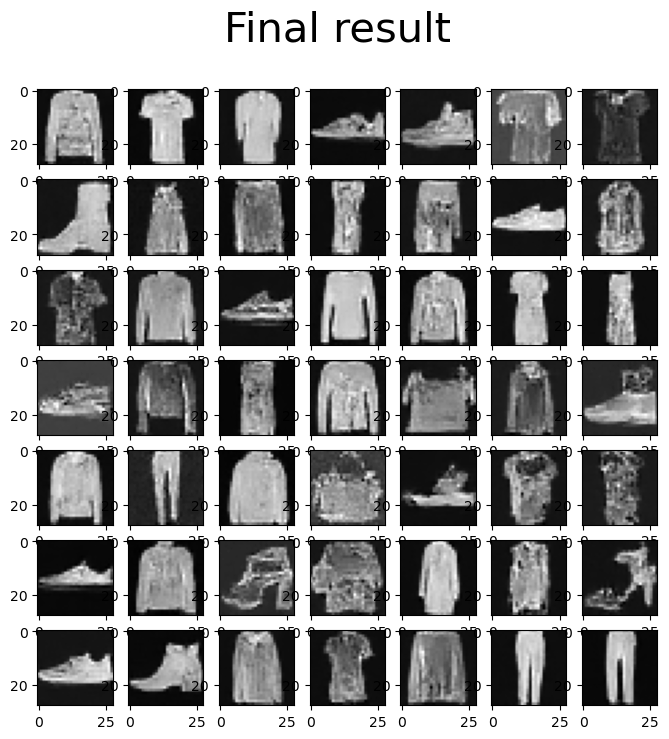

In [14]:
print("Generating new images")
generated = generate_new_images(
        best_model,
        n_samples=49,
        device=device,
        gif_name="Fmnist.gif"
    )
show_images(generated, "Final result")

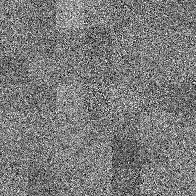

In [15]:
from IPython.display import Image 
Image(open('Fmnist.gif', 'rb').read())